## TTS with Tacotron2 + Waveflow

In [1]:
import numpy as np
import paddle
from matplotlib import pyplot as plt
from IPython import display as ipd
%matplotlib inline

from parakeet.utils import display
from parakeet.utils import layer_tools
paddle.set_device("gpu:5")

import sys
sys.path.append("/home/chenfeiyu/project/Parakeet_0.2")
import examples

## Tacotron2: synthesizer model

Tacotron2 is used here as a phonemes to spectrogram model. Here we will use an alternative config. In this config, the tacotron2 model does not have a binary classifier to predict whether the generation should stop.

Instead, the peak position is used as the criterion. When the peak position of the attention reaches the end of the encoder outputs, it implies that the content is exhausted. So we stop the generated after 10 frames.

In [2]:
from parakeet.models.tacotron2 import Tacotron2
from parakeet.frontend import EnglishCharacter

In [3]:
from examples.tacotron2 import config as tacotron2_config
synthesizer_config = tacotron2_config.get_cfg_defaults()
synthesizer_config.merge_from_file("configs/alternative.yaml")
print(synthesizer_config)

data:
  batch_size: 32
  d_mels: 80
  fmax: 8000
  fmin: 0
  hop_length: 256
  n_fft: 1024
  padding_idx: 0
  sample_rate: 22050
  valid_size: 64
  win_length: 1024
model:
  attention_filters: 32
  attention_kernel_size: 31
  d_attention: 128
  d_attention_rnn: 1024
  d_decoder_rnn: 1024
  d_encoder: 512
  d_postnet: 512
  d_prenet: 256
  encoder_conv_layers: 3
  encoder_kernel_size: 5
  guided_attention_loss_sigma: 0.2
  p_attention_dropout: 0.1
  p_decoder_dropout: 0.1
  p_encoder_dropout: 0.5
  p_postnet_dropout: 0.5
  p_prenet_dropout: 0.5
  postnet_conv_layers: 5
  postnet_kernel_size: 5
  reduction_factor: 1
  use_guided_attention_loss: True
  use_stop_token: False
  vocab_size: 37
training:
  grad_clip_thresh: 1.0
  lr: 0.001
  max_iteration: 500000
  plot_interval: 1000
  save_interval: 1000
  valid_interval: 1000
  weight_decay: 1e-06


In [4]:
frontend = EnglishCharacter()
model = Tacotron2.from_pretrained(
    synthesizer_config, "runs/refactor/checkpoints/step-21000")
model.eval()

[checkpoint] Rank 0: loaded model from runs/refactor/checkpoints/step-21000.pdparams


In [5]:
sentence = "Life was like a box of chocolates, you never know what you're gonna get." 
sentence = paddle.to_tensor(frontend(sentence)).unsqueeze(0)

with paddle.no_grad():
    outputs = model.infer(sentence)
mel_output = outputs["mel_outputs_postnet"][0].numpy().T
alignment = outputs["alignments"][0].numpy().T

 36%|███▌      | 355/1000 [00:01<00:02, 267.97it/s]

content exhausted!


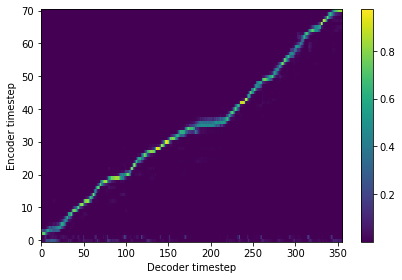

In [6]:
display.plot_alignment(alignment)

## WaveFlow: vocoder model
Generated spectrogram is converted to raw audio using a pretrained waveflow model.

In [7]:
from parakeet.models.waveflow import ConditionalWaveFlow

In [8]:
from examples.waveflow import config as waveflow_config
vocoder_config = waveflow_config.get_cfg_defaults()
print(vocoder_config)

data:
  batch_size: 8
  clip_frames: 65
  fmax: 8000
  fmin: 0
  hop_length: 256
  n_fft: 1024
  n_mels: 80
  sample_rate: 22050
  valid_size: 16
  win_length: 1024
model:
  channels: 128
  kernel_size: [3, 3]
  n_flows: 8
  n_group: 16
  n_layers: 8
  sigma: 1.0
  upsample_factors: [16, 16]
training:
  lr: 0.0002
  max_iteration: 3000000
  save_interval: 10000
  valid_interval: 1000


In [9]:
vocoder = ConditionalWaveFlow.from_pretrained(
    vocoder_config, 
    "/home/chenfeiyu/projects/Parakeet_0.2/examples/waveflow/pretrained/waveflow_ljspeech_ckpt_0.2/step-2000000")
layer_tools.recursively_remove_weight_norm(vocoder)
vocoder.eval()

[checkpoint] Rank 0: loaded model from /home/chenfeiyu/projects/Parakeet_0.2/examples/waveflow/pretrained/waveflow_ljspeech_ckpt_0.2/step-2000000.pdparams


In [10]:
audio = vocoder.infer(paddle.transpose(outputs["mel_outputs_postnet"], [0, 2, 1]))
wav = audio[0].numpy()

time: 9.308465242385864s


In [11]:
ipd.Audio(wav, rate=22050)